# Estimation of failure probability due to wave run-up (Hunt's equation)

In this example, we will demonstrate the application of various reliability methods (`directional_sampling`, `importance_sampling`, `adaptive_importance_sampling`, `subset_simulation`) to estimate the probability of failure of a levee due to wave run-up. The failure mechanism is characterized by the Hunt's equation, which is a simple model to estimate the wave run-up.

### Define model

First, we import the necessary classes:

In [9]:
from probabilistic_library import ReliabilityProject, DistributionType, ReliabilityMethod, SampleMethod

We consider the following limit state function:

$Z = h_{crest} - (h + R_u)$

where: <br>

$h_{crest}$ is the crest height of the flood defence (m) <br>
$h$ is the water level on the flood defence (m) <br>
$R_u$ represents the wave run-up (m)

The wave run-up $R_u$ is derived using the Hunt's equation:

$R_u = \xi \cdot H_s$

with:

$\xi = \frac{\tan (\alpha)}{\sqrt{2\cdot \pi \cdot H_s/L_0}} $

$L_0 = g \cdot T_p^2$

where:

$H_s$ is the significant wave height (m) <br>
$T_p$ is the peak wave period (s) <br>
$g$ is the gravitational acceleration ($9.81 m/s ^2$) <br>
$\tan (\alpha)$ is the slope of the flood defence (-)

The parameters $h$, $H_s$ and $T_p$ represent the imposed load, while $h_{crest}$ and $\tan (\alpha)$ stand for the strength of the levee.

In [10]:
from utils.models import hunt

To perform a reliability analysis, we create a reliability project and specify the limit state function (model):

In [11]:
project = ReliabilityProject()
project.model = hunt

project.model.print()

Model hunt:
Input parameters:
  t_p
  tan_alpha
  h_s
  h_crest
  h
Output parameters:
  Z


We assume the following distributions for the parameters present in the limit state function:

In [12]:
project.variables["t_p"].distribution = DistributionType.log_normal
project.variables["t_p"].mean = 3
project.variables["t_p"].deviation = 1

project.variables["tan_alpha"].distribution = DistributionType.deterministic
project.variables["tan_alpha"].mean = 0.333333

project.variables["h_s"].distribution = DistributionType.log_normal
project.variables["h_s"].mean = 3
project.variables["h_s"].deviation = 1

project.variables["h_crest"].distribution = DistributionType.log_normal
project.variables["h_crest"].mean = 10
project.variables["h_crest"].deviation = 0.05

project.variables["h"].distribution = DistributionType.exponential
project.variables["h"].shift = 0.5
project.variables["h"].scale = 1

### Perform reliability calculations with Directional Sampling

We start with the reliability method `directional_sampling`. The reliability analysis is executed using `project.run()`, and the results are accessed from `project.design_point`.

Reliability (Directional Sampling)
 Reliability index = 3.0678
 Probability of failure = 0.0011
 Convergence = 0.0275 (not converged)
 Model runs = 111509
Alpha values:
 t_p: alpha = -0.3346, x = 3.9715
 tan_alpha: alpha = 0.0, x = 0.3333
 h_s: alpha = -0.1756, x = 3.3899
 h_crest: alpha = 0.0068, x = 9.9988
 h: alpha = -0.9258, x = 6.5951



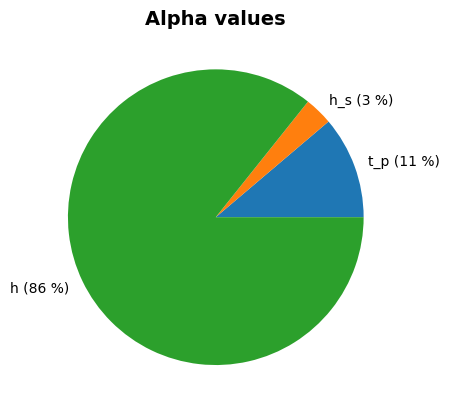

In [13]:
project.settings.reliability_method = ReliabilityMethod.directional_sampling
project.settings.minimum_directions = 10000
project.settings.maximum_directions = 20000
project.settings.variation_coefficient = 0.02

project.run()

project.design_point.print()
project.design_point.plot_alphas()

### Perform reliability calculations with Importance Sampling

We now conduct the reliability analysis using the `importance_sampling` assuming the start value of $u=1$ for the three random variables:

Reliability:
 Reliability index = 3.072
 Probability of failure = 0.0011
 Convergence = 0.0234 (not converged)
 Model runs = 100001
Alpha values:
 t_p: alpha = -0.3346, x = 3.9731
 tan_alpha: alpha = 0.0, x = 0.3333
 h_s: alpha = -0.1721, x = 3.3789
 h_crest: alpha = 0.0093, x = 9.9984
 h: alpha = -0.9265, x = 6.6134



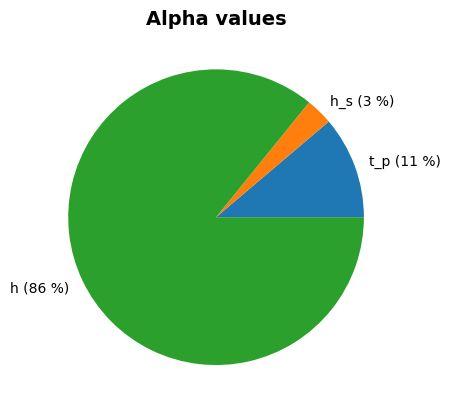

In [14]:
project.settings.reliability_method = ReliabilityMethod.importance_sampling
project.settings.minimum_samples = 1000
project.settings.maximum_samples = 100000
project.settings.variation_coefficient = 0.02

project.settings.stochast_settings["t_p"].start_value = 1
project.settings.stochast_settings["h_s"].start_value = 1
project.settings.stochast_settings["h"].start_value = 1

project.run()

project.design_point.print()
project.design_point.plot_alphas()

#reset values
project.settings.stochast_settings["t_p"].start_value = 0
project.settings.stochast_settings["h_s"].start_value = 0
project.settings.stochast_settings["h"].start_value = 0

### Perform reliability calculations with Adaptive Importance Sampling

We now conduct the reliability analysis using the `adaptive_importance_sampling` method.

Reliability:
 Reliability index = 3.089
 Probability of failure = 0.001
 Convergence = 0.0461 (not converged)
 Model runs = 100001
Alpha values:
 t_p: alpha = -0.3506, x = 4.0451
 tan_alpha: alpha = 0.0, x = 0.3333
 h_s: alpha = -0.1736, x = 3.387
 h_crest: alpha = -0.0017, x = 10.0001
 h: alpha = -0.9203, x = 6.6028

Contributing design points:
  Reliability (Variance loop 1)
   Reliability index = 3.0738
   Probability of failure = 0.0011
   Convergence = 0.1529 (not converged)
   Model runs = 10001
  Alpha values:
   t_p: alpha = -0.3606, x = 4.0786
   tan_alpha: alpha = 0.0, x = 0.3333
   h_s: alpha = -0.2178, x = 3.537
   h_crest: alpha = -0.0219, x = 10.0032
   h: alpha = -0.9066, x = 6.4291

  Reliability (Variance loop 2)
   Reliability index = 3.0715
   Probability of failure = 0.0011
   Convergence = 0.1486 (not converged)
   Model runs = 10001
  Alpha values:
   t_p: alpha = -0.2932, x = 3.8126
   tan_alpha: alpha = 0.0, x = 0.3333
   h_s: alpha = -0.147, x = 3.2952
   h_cre

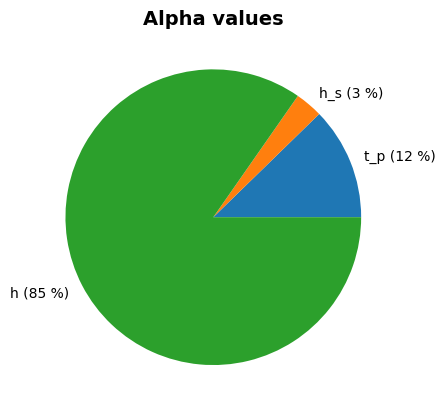

In [15]:
project.settings.reliability_method = ReliabilityMethod.adaptive_importance_sampling
project.settings.minimum_samples = 10000
project.settings.maximum_samples = 100000
project.settings.minimum_variance_loops = 5
project.settings.maximum_variance_loops = 10
project.settings.fraction_failed = 0.5
project.settings.variation_coefficient = 0.02

project.run()

project.design_point.print()
project.design_point.plot_alphas()

### Perform reliability calculations with Subset Simulation

We now conduct the reliability analysis using the `subset_simulation` method.

Reliability:
 Reliability index = 3.0767
 Probability of failure = 0.001
 Convergence = 0.0131 (not converged)
 Model runs = 45000
Alpha values:
 t_p: alpha = -0.3517, x = 4.0439
 tan_alpha: alpha = 0.0, x = 0.3333
 h_s: alpha = -0.1625, x = 3.3476
 h_crest: alpha = 0.0257, x = 9.9959
 h: alpha = -0.9215, x = 6.5794

Contributing design points:
  Reliability (Subset iteration 1)
   Reliability index = 3.0618
   Probability of failure = 0.0011
   Convergence = 0.1348 (not converged)
   Model runs = 50001
  Alpha values:
   t_p: alpha = -0.299, x = 3.8309
   tan_alpha: alpha = 0.0, x = 0.3333
   h_s: alpha = -0.1287, x = 3.2345
   h_crest: alpha = -0.0471, x = 10.0071
   h: alpha = -0.9444, x = 6.7568

  Reliability (Subset iteration 2)
   Reliability index = 3.0746
   Probability of failure = 0.0011
   Convergence = 0.0433 (not converged)
   Model runs = 45000
  Alpha values:
   t_p: alpha = -0.3562, x = 4.0609
   tan_alpha: alpha = 0.0, x = 0.3333
   h_s: alpha = -0.1712, x = 3.3763
  

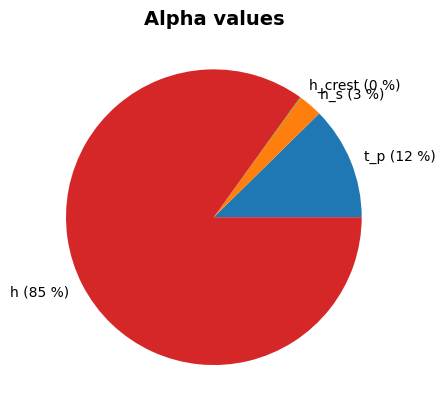

In [16]:
project.settings.reliability_method = ReliabilityMethod.subset_simulation
project.settings.minimum_samples = 1000
project.settings.maximum_samples = 50000
project.settings.variation_coefficient = 0.02
project.settings.sample_method = SampleMethod.adaptive_conditional

project.run()

project.design_point.print()
project.design_point.plot_alphas()